![Texto alternativo](https://laserud.co/wp-content/uploads/2020/05/cropped-LOGOLASER-1.jpg "Grupo LASER")

# Detección de Anomalías en Series de Tiempo
Las series de tiempo están comúnmente en nuestro entorno. Podemos mencionar ejemplos como el precio diario del petróleo, mediciones de variables ambiente, etc. Las series de tiempo son evidentes en todas las industrias de alguna manera.

Debido a su popularidad, es uno de los tipos de datos más investigados. Como generalidad, una serie de tiempo se caracteriza porque las mediciones se realizan en intervalos de tiempo fijos, por ejemplo, cada 15 minutos, cada hora, etc. Dada la periodicidad de las mediciones, los registros están correlacionados en el tiempo.

Mientras analizamos las series de tiempo, debemos dar cuenta de los valores atípicos o anómalos. Se puede decir que un valor anómalo es una observación que se desvía tanto de otras observaciones como para despertar la sospecha de que ha sido generada por un mecanismo diferente.

Los valores anómalos en las series de tiempo pueden ser interpretados principalmente de dos formas: como un dato no esperado o como un evento de interés. La distinción entre estos dos tipos de datos se basa principalmente en el interés particular del analista o del escenario de análisis.

Estas observaciones relacionadas con ruido, datos erróneos o no esperados, que en sí mismos no son de interés para el analista, deben ser eliminadas o corregidas para mejorar la calidad de los datos. Se debe tener en cuenta que estas tareas de limpieza de datos se ejecutan para poder utilizar la el conjunto de datos con otros algoritmos.

El otro punto de vista, se refiere a la tarea de detectar y analizar fenómenos inusuales, pero interesantes. Un buen ejemplo es la detección de fraude, donde el objetivo principal es detectar y analizar el propio fenómeno anómalo.

El problema de la detección de anomalías en las series temporales suele formularse como la identificación de puntos de datos atípicos en relación con alguna norma o señal habitual. Veamos algunos tipos de valores atípicos:

- Valor atípico puntual: un valor atípico puntual es un dato que se comporta de forma inusual en un momento determinado cuando se compara con los demás valores de una serie temporal (outlier global), o con sus puntos vecinos (outlier local).
- Valor atípico subsecuente: Se trata de puntos consecutivos en el tiempo cuyo comportamiento en conjunto es inusual, aunque cada valor por separado no es un necesariamente un valor atípico puntual. Los valores atípico subsecuentes pueden ser locales o globales y también pueden afectar a una (valor atípico subsecuente univariante) o más (valor atípico subsecuente multivariante) variables dependientes del tiempo.

Hay algunas técnicas que los analistas pueden utilizar para detectar diferentes valores anómalos en series de tiempo. Vamos a ver algunas de ellas, sin embargo, primero debemos cargar todas las librerías que usaremos:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from adtk.visualization import plot
from adtk.data import validate_series

En este caso vamos a utilizar un conjunto de datos real, se trata de mediciones de temperatura de un sensor. Utilizando pandas leemos un archivo csv, donde el delimitador es “;” y adicionalmente indicamos los nombres de las columnas de datos. Estas mediciones tienen un periodo de muestreo de 10 minutos, que utilizaremos como índice. Eliminamos la columna "muestra", pues estos datos ya están en el indice del DataFrame.

In [2]:
url = "https://github.com/LASER-UD/machinelearning/blob/main/SeriesDeTiempo/Anomaly-TimeSeries/TEMP_selected.csv?raw=true"

data = pd.read_csv(url, names=['muestra','temp'], delimiter=';')
data = data.drop(data.index[[0]])
data.set_index(
    pd.PeriodIndex(np.array(data.muestra), freq="10min"),
    inplace=True,
)
data.drop("muestra", axis=1, inplace=True)

En los datos de temperatura el indicador de decimales originalmente viene “,” necesitamos reemplazarlo por “.”. Posteriormente, podemos convertir estos datos a número flotante.

Adicionalmente, debemos convertir el índice de tiempo a un formato estándar. Utilizamos la conversión a time stamp. Podemos graficar la serie de tiempo.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78519 entries, 2019-02-03 12:40:00 to 2020-08-01 19:00:00
Freq: 10T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    74511 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


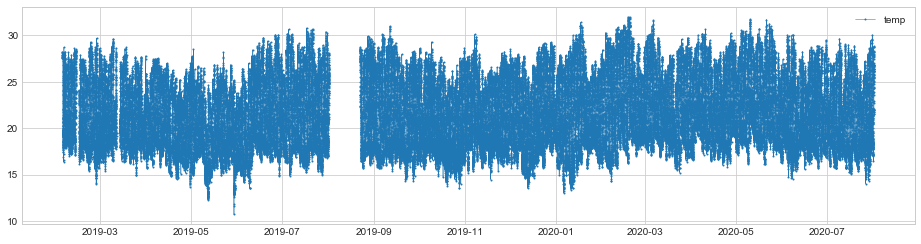

In [3]:
data['temp']= data['temp'].str.replace(',','.')
data['temp']= data['temp'].astype(float)

data.index = data.index.to_timestamp()

data.info()

plot(data)

En la serie de tiempo podemos observar varios datos no graficados. Estos son datos NaN, inicialmente vamos a rellenar estos valores con 0. Y verificaremos si tenemos datos nulos adicionales. Graficaremos nuevamente la serie de tiempo y haremos una copia de los datos originales. Podemos esperar que los datos que hemos rellenado con 0 sean detectados como anomalías en la mayoría de los casos, vamos a ver como funcionan los algoritmos explorados.

0


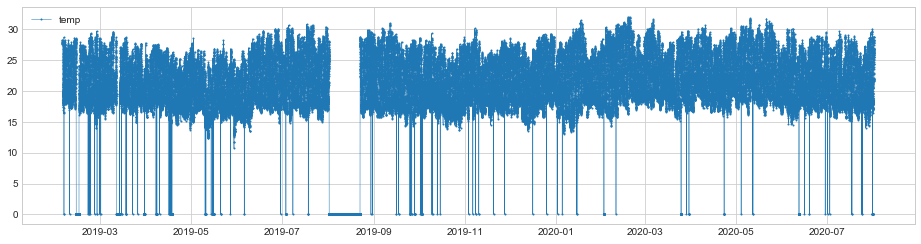

In [4]:
data['temp'] = data['temp'].fillna(0)

print(data['temp'].isnull().sum())

data = validate_series(data)

plot(data)

orig_data = data.copy()

## Árboles de Decisión: Isolation Forest
Podemos utilizar la potencia y la solidez de los árboles de decisión para identificar valores atípicos/anómalos en datos de series tiempo.
-	Podemos utilizar aprendizaje supervisado para enseñar a los arboles de decisión a clasificar los datos anómalos y no anómalos. Para lograr esto, debemos tener los puntos de datos anómalos etiquetados, lo cual no nos encontraremos comúnmente.
-	La otra alternativa más realista es el aprendizaje no supervisado. Para esto podemos utilizar el algoritmo Isolation Forest para predecir cuando un punto se considera anómalo, sin la necesidad de tener un conjunto de datos etiquetado.

La idea principal es que el algoritmo Isolation Forest identifica explícitamente anomalías en lugar de perfilar los puntos de datos normales. Este algoritmo se basa en los árboles de decisión.

El algoritmo IsolationForest "aísla" las observaciones seleccionando aleatoriamente una característica y, a continuación, seleccionando aleatoriamente un valor de partición entre los valores máximo y mínimo de la característica seleccionada.

Dado que la partición recursiva puede representarse mediante una estructura de árbol, el número de divisiones necesarias para aislar una muestra es equivalente a la longitud del camino desde el nodo raíz hasta el nodo final.

Esta longitud del camino, promediada sobre un bosque de tales árboles aleatorios, es una medida de normalidad y nuestra función de decisión.

La partición aleatoria produce caminos notablemente más cortos para las anomalías. Por lo tanto, cuando un bosque de árboles aleatorios produce colectivamente trayectorias más cortas para determinadas muestras, es muy probable que se trate de anomalías.

Isolation Forest detecta anomalías basándose puramente en el hecho de que las anomalías son menos y diferentes. El aislamiento de las anomalías se realiza sin utilizar ninguna distancia o medida de densidad. 
Cuando utilizamos el algoritmo Isolation Forest debemos definir el parámetro outlier_fraction. Este indica al modelo cual es la proporción de anomalías presente en los datos. Es un parámetro que se debe afinar mediante pruebas.

Primero vamos a importar la implementación del algoritmo Isolation Forest de SciKit Learn. Vamos a tomar los datos originales y el índice de los datos para su posterior uso. Indicamos la fracción de datos anómalos que hay en el conjunto; recordemos que este parámetro se debe ajustar de acuerdo con los resultados obtenidos.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

data = orig_data.copy()
orig_index = data.index

outlier_frac= 0.10

Con el objetivo de obtener mejores resultados, vamos a normalizar los datos entre (-1,1). Para esto utilizaremos el módulo StandardScaler de SciKit Learn. Estos datos los almacenamos en un dataframe, conservando el índice original.

In [6]:
scaler = StandardScaler()

np_scaled = scaler.fit_transform(data.values.reshape(-1,1))
data = pd.DataFrame(np_scaled, index=orig_index, columns=['temp'])


Declaramos el objeto IsolationForest, y utilizamos como parámetro el porcentaje de otuliers que habíamos declarado anteriormente. Entrenamos el modelo con el conjunto de datos disponibles y finalmente, utilizamos el modelo para realizar las predicciones sobre el conjunto de datos y guardamos esta información en una nueva columna del conjunto de datos.

In [7]:
model = IsolationForest(contamination=outlier_frac)
model.fit(data)

data['anomaly'] = model.predict(data)


Retornamos los datos al rango original y guardamos esta información junto con la columna de anomalías, previamente creada.

In [8]:
np_scaled = scaler.inverse_transform(data['temp'].values.reshape(-1,1))
data['temp'] = pd.DataFrame(np_scaled, index=orig_index, columns=['temp'])

data.head()

,temp,anomaly
2019-02-03 12:40:00,27.90,1
2019-02-03 12:50:00,27.85,1
2019-02-03 13:00:00,27.60,1
2019-02-03 13:10:00,27.75,1
2019-02-03 13:20:00,27.60,1


Ahora graficamos los datos “normales” y las anomalías. Podemos observar cómo detecta varios valores extremos como anomalías, sin embargo, es necesario sintonizar el modelo quizá con un porcentaje mayor de anomalías para que detecte los datos rellenados con 0 como anomalías.

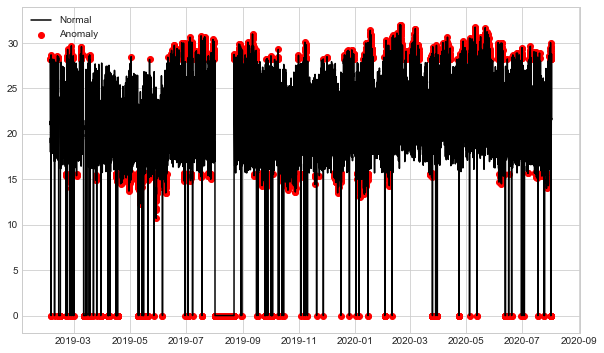

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
a = data.loc[data['anomaly'] == -1, ['temp']] #anomaly
ax.plot(data.index, data['temp'], color='black', label = 'Normal')
ax.scatter(a.index,a['temp'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

## Predicción: fbprophet
La detección de anomalías mediante predicción se basa en un enfoque en el que usando varios puntos del pasado se genera una predicción del siguiente punto con la adición de alguna variable aleatoria, que suele ser ruido blanco.

Como te puedes imaginar, las predicciones en el futuro generarán nuevos puntos y así sucesivamente. Su efecto es evidente en el horizonte de previsión: la señal se suaviza.

La parte difícil de seleccionar este método es que debemos seleccionar el número de diferencias, el número de auto regresiones y los coeficientes de error de predicción.
Cada vez que trabajes con una nueva señal, debes construir un nuevo modelo de predicción.

El proceso para detectar anomalías es:
-	Predecir el nuevo punto a partir de los datos anteriores y encontrar la diferencia de magnitud con los datos de entrenamiento.
-	Elegir un umbral e identificar las anomalías basado en ese umbral de diferencia.

Para probar esta técnica, vamos a utilizar un módulo de series de tiempo popular llamado fbprophet. Este módulo atiende específicamente a la estacionariedad y a la estacionalidad, y puede ajustarse con algunos hiperparámetros.

Primero importamos la librería fbprophet, y vamos a dejar definida una función que utilizaremos posteriormente para detectar las anomalías. En esta función tomamos las predicciones realizadas y con la información de tendencia (tren), valor de la predicción (yhat), los limites superior (yhat_hupper) e inferior (yhat_lower), el índice de tiempo (ds) y la señal de salida original (fact). Con base en estas mediciones se determina cuando un dato es normal o anómalo.


In [10]:
from fbprophet import Prophet

def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted


Importing plotly failed. Interactive plots will not work.


El primer hiperparámetro que definimos es interval_width: La predicción de Prophet devuelve intervalos de incertidumbre para cada componente, como yhat_lower y yhat_upper para la predicción yhat. Estos se calculan como cuantiles de la distribución de predicción posterior, y interval_width especifica qué cuantiles utilizar. El valor predeterminado de 0,8 proporciona un intervalo de predicción del 80%. Puede cambiarlo a 0,95 si desea un intervalo del 95%. Esto sólo afectará al intervalo de incertidumbre, y no cambiará en absoluto la predicción de yhat, por lo que no es necesario ajustarlo.

El segundo hiperparámetro que definimos es changepoint_range: Es la proporción de la historia en la que se permite que la tendencia cambie. El valor predeterminado es 0,8, el 80% de la historia, lo que significa que el modelo no ajustará ningún cambio de tendencia en el último 20% de la serie temporal. Esto es bastante conservador, para evitar un ajuste excesivo a los cambios de tendencia al final de la serie de tiempo donde no hay suficiente recorrido para ajustarlo bien. Es mejor no ajustar este parámetro, excepto en el caso de un gran número de series temporales. En ese caso, [0,8, 0,95] puede ser un rango razonable.

Instanciamos un nuevo objeto Prophet, con algunos hiperparámetros especificados. Posteriormente, entrenamos el modelo con los datos disponibles.


In [11]:
data = pd.DataFrame()
data['ds'] = orig_data.index
data['y'] = orig_data.values

interval_width = 0.95
changepoint_range = 0.80

m = Prophet(daily_seasonality = False, yearly_seasonality = False,
            weekly_seasonality = False, seasonality_mode = 'additive',
            interval_width = interval_width,
            changepoint_range = changepoint_range)

m = m.fit(data)


Ahora vamos a llamar la función de predicción. Algo que debemos notar es que fbprophet añadirá algunas métricas adicionales como características, con el objetivo de identificar mejor las anomalías. Por ejemplo, la predicción de la serie de tiempo, los límites inferior y superior y la métrica de tendencia.

Aquí, llamamos la función detect_anomalies e imprimiremos cuantos de los datos se han detectado como anomalía; Recordemos que los datos "normales" son etiquetados en la columna "anomaly" con 0.

In [12]:
pred = m.predict(data)
pred['fact'] = data['y'].reset_index(drop = True)

pred = detect_anomalies(pred)

print(np.count_nonzero(pred['anomaly'].values))


2469


Graficamos los resultados obtenidos, podemos observar que los datos que hemos rellenado con cero afectan en gran medida los resultados de la predicción. Sin embargo, se detectan de buena manera los datos anómalos.

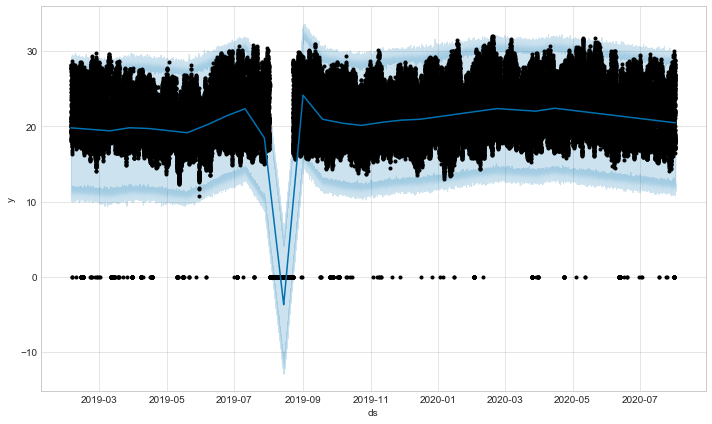

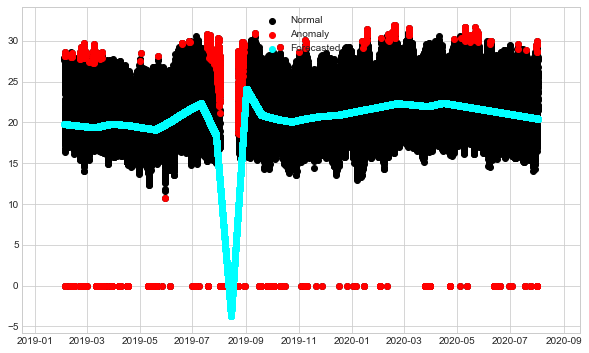

In [13]:
norm = pred[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

m.plot(norm)

fig, ax = plt.subplots(figsize=(10,6))
a = pred.loc[pred['anomaly'] != 0,['ds','fact']] #anomaly
ax.scatter(pred['ds'], pred['fact'], color='black', label = 'Normal')
ax.scatter(a['ds'],a['fact'], color='red', label = 'Anomaly')
ax.scatter(pred['ds'],pred['yhat'], color='cyan', label = 'Forecasted')
plt.legend()
plt.show()

## Agrupaciones
### K-Means
Este enfoque es relativamente sencillo. Los ejemplos que estén por fuera de unos clusters definidos, potencialmente serán marcados como anómalos. Como primera alternativa usaremos el popular algoritmo k-means.

Para este algoritmo, primero debemos saber el número de clusters a implementar. Para definir esto, podemos utilizar el método del codo. Este consiste en una gráfica del número de clusters vs la varianza.De esta curva, podemos identificar que el número de clusters a utilizar puede ser 8. Implicando que la adición de más clusters no representa mucho más de la varianza en nuestra variable relevante.

Usaremos los siguientes pasos para buscar las anomalías:
-	Calcular la distancia entre cada punto su centroide más cercano. Las mayores distancias son consideradas anomalías.
-	Utilizaremos el parámetro outlier_fraction para dar información al algoritmo a cerca de la porción de los outliers presente en nuestro conjunto de datos. Este hiper parámetro necesita de prueba y error; su función es similar a la prestada para el algoritmo Isolation Forest.
-	Establecemos el umbral como la distancia mínima de estos valores atípicos.

La mayor ventaja de esta técnica es similar a la de otras técnicas no supervisadas, y es que se pueden introducir tantas variables aleatorias o características como se quiera para hacer modelos más sofisticados.

Primero llamamos los modulos necesarios, en este caso utilizaremos SciKit-Learn para la implementación del algoritmo. Definimos una función que calcula la distancia entre un punto y un centroide de un cluster y retorna las distancias en una serie de pandas.

In [14]:
from sklearn.cluster import KMeans

def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.iloc[i][0])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)


Tomamos los datos, definimos la fracción de datos anómalos y definimos un rango para realizar las variaciones en el número de clusters.

Entrenamos los modelos con el número de clusters entre 1 y 20. Calculamos su puntaje de varianza y graficamos el número de clusters contra la varianza.

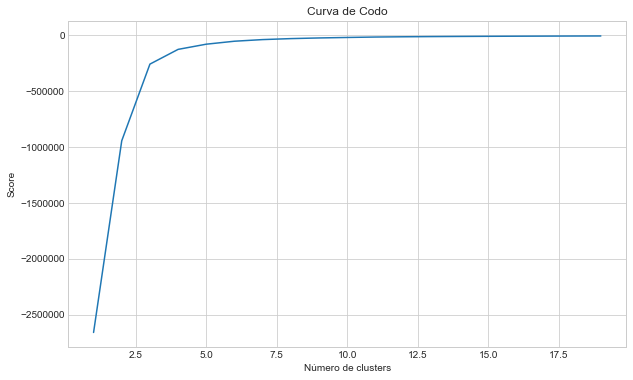

In [15]:
data = orig_data.copy()
outlier_frac = 0.10

n_cluster = range(1,20)

kmeans = [KMeans(n_clusters=i).fit(data.values) for i in n_cluster]
scores = [kmeans[i].score(data.values) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Número de clusters')
plt.ylabel('Score')
plt.title('Curva de Codo')
plt.show();


De la curva anterior podemos establecer que el número de clusters puede estar entre 5 y 7 aproximadamente. Para este ejercicio elegimos 6 clusters, con este entrenamiento calculamos las distancias y con el parámetro de la proporción de anomalías podemos intentar identificar los datos que están lo suficientemente alejados del cluster como para considerarlos anómalos.

In [16]:
labels = kmeans[5].predict(data.values)
uniq_elem, count_elem = np.unique(labels, return_counts=True)

clusters = np.asanyarray((uniq_elem,count_elem))

distance = getDistanceByPoint(data, kmeans[5])

num_outlier = int(outlier_frac*len(distance))

threshold = distance.nlargest(num_outlier).min()

data['anomaly'] = (distance >= threshold).astype(int)


Graficamos los resultados obtenidos, podemos observar que se obtienen buenos resultados pues se marcan como outliers los puntos que definimos en ceros en la etapa de preprocesamiento. Es importante recordar que estos resultados dependen de los parámetros establecidos, como el número de clusters, el procentaje de outliers, la métrica de distancia, etc.

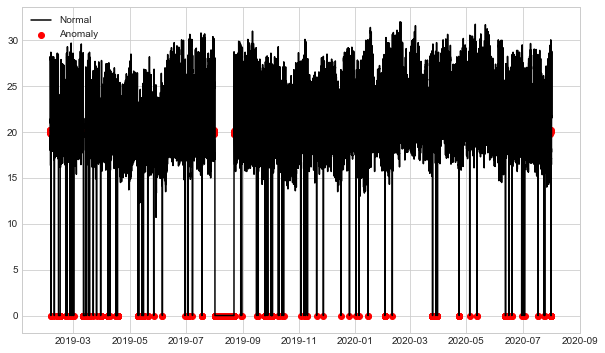

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
a = data.loc[data['anomaly'] == 1, ['temp']] #anomaly
ax.plot(data.index, data['temp'], color='black', label = 'Normal')
ax.scatter(a.index,a['temp'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

### DBSCAN
Como segunda alternativa en los métodos basados en agrupamiento está el algoritmo DBSCAN.

DBSCAN es un algoritmo de clustering basado en la densidad. Determina los puntos centrales del conjunto de datos que contienen al menos un mínimo de muestras (que debemos definir) a su alrededor dentro de una distancia épsilon (configurable). Basando en las muestras crea clusters, y encuentra todos los puntos que son densamente alcanzables (dentro de la distancia epsilon) desde cualquier muestra en el cluster y los añade al mismo. Luego, iterativamente, realiza el mismo procedimiento para nuevas muestras añadidas y amplía el cluster.

Una de las grandes ventajas de DBSCAN es que determina el número de clusters por sí mismo. En nuestro caso, es de interés conocer que las muestras atípicas se asignarán como -1. Por lo cual, directamente realizaremos la detección de anomalías.

Cuando instanciamos el objeto DBSCAN definimos dos parámetros. 
-	Eps: La distancia máxima entre dos muestras para que una se considere en la vecindad de la otra. No se trata de un límite máximo en las distancias de los puntos dentro de un cluster. Este es el parámetro más importante de DBSCAN para elegir adecuadamente para su conjunto de datos y función de distancia.
-	El número de muestras (o el peso total) en una vecindad para que un punto sea considerado como punto central. Esto incluye el punto propio.


In [18]:
from sklearn.cluster import DBSCAN

data = orig_data.copy()

dbscan = DBSCAN(eps=0.05, min_samples=20).fit(data.values)


Entrenamos el modelo con los datos disponibles e identificamos donde están las muestras atípicas buscando los datos etiquetados con -1. Estos datos no son asignados a ningún cluster, se intuye que están lo suficientemente lejos como para que se produzca este fenómeno.

In [19]:
labels = dbscan.labels_
outlier_pos = np.where(labels == -1)[0] #indice

a = data.iloc[outlier_pos]


Graficamos los resultados, pudiendo notar que algunos puntos extremos fueron identificados como outlier.

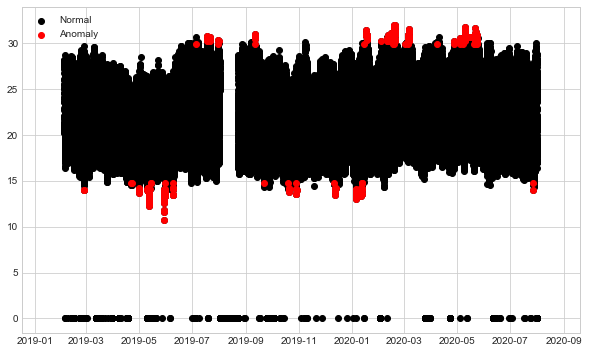

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data.index, data['temp'], color='black', label = 'Normal')
ax.scatter(a.index, a['temp'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

Debemos tener en cuenta que el algoritmo DBSCAN puede sufrir problemas de rendimiento con conjuntos de datos de gran tamaño. Esto se debe a que calcula las distancias de todos los puntos con cada cluster para definir la pertenencia de un vecino en el agrupamiento.